# Unpaired image translation with CycleGAN (Monet paintings)

This was a attempt at creating a Cycle Generative Adversial Network (CycleGAN) model to conduct style transfer and acts as both my 'notes' and my first exposure to deep learning and convolutional neural networks in general.

This notebook is created solely for learning purposes, so do let me know of any areas to improve on.

This project relied heavily on this CycleGAN tutorial by Jason Brownlee (https://machinelearningmastery.com/cyclegan-tutorial-with-keras/), this medium article by Mehul Gupta (https://medium.com/data-science-in-your-pocket/understanding-cyclegans-using-examples-codes-f5d6e1a47048) and the Monet painting dataset from Kaggle.

# Loading in packages

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.4 MB/s 


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Model
import tensorflow_addons as tfa
import os
import random
import PIL
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image

# Loading in the data

We will start by loading in the JPG files that contain our Monet paintings and the ordinary photo which we plan to convert into Monet-styled images. We can do so using the Pillow package.

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [8]:
# Let's take a look at the features of some images in our dataset.
image = Image.open("/content/gdrive/MyDrive/Colab Notebooks/monet_jpg/000c1e3bff.jpg")

# Prints out some basic information about the image.
print("Format: {a}, Mode: {b}, Size: {c}".format(a = str(image.format), b = str(image.mode), c = str(image.size)))

Format: JPEG, Mode: RGB, Size: (256, 256)


In [10]:
# Create a function to help us load images into a numpy array.

def load_images(folder):
    loaded_images = []
    
    # Loop through the filename given, convert images to a numpy array, and append it to loaded images.    
    for filename in os.listdir(folder):
        image_data = np.array(Image.open(folder + "/" + filename))
        loaded_images.append(image_data)
        
    return loaded_images

# Load in our data as numpy arrays.
df_monet = load_images('/content/gdrive/MyDrive/Colab Notebooks/monet_jpg')
df_photos = load_images('/content/gdrive/MyDrive/Colab Notebooks/photo_jpg')

In [11]:
# We can now confirm that all paintings and photos are loaded in.
print(len(df_monet))
print(len(df_photos))

300
7038


In [12]:
# Take a look at the shape of a paintings
print(len(df_monet[0]))

256


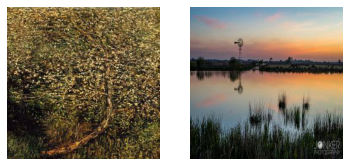

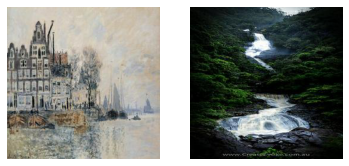

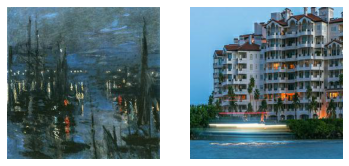

In [13]:
# Let's take a look at some images we have
# The left column houses our Monet paintings
# The right column houses our background photos
for i in range(3):
    fig, ax = plt.subplots(1, 2)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].imshow(df_monet[i])
    ax[1].imshow(df_photos[i])

Because my computer is a potato, it would take too long to use all 7038 photos - for now we will just be using 300 of those to develop our CycleGAN model, we will also save the rest as test inputs to our final model.

# Building the models

Now we can begin to combine both our discriminator and generator models to create a composite model which takes in images of normal backgrounds and return the same background, but in the style of a Monet painting.

The first step follows a traditional GAN model. We will take a generator model (Gen1) to create fake images of Monet paintings from real images of normal backgrounds, it will then try to fool our discriminator model (Dis1), outputs from Gen1 will be sent to Dis1 together with real images of monet paintings. Gen1 will slowly learn from Dis and improve it's fake images.

We will also have another generator model (Gen2), which will focus on reverting our fake monet painting back to the original normal background. It will also come with its corresponding discriminator model (Dis2). Output from Gen1 will be passed into Gen2, which will then be passed into Dis2 along with the original real image of normal background. This helps us manage how much the original normal background has been changed by Gen1 to try to fool Dis1, we do not want a output that ends up completely different from the original normal background.

The model is trained by considering 3 different types of losses.

    1) Adversial loss: Applied to the generator models. This refers to the loss that comes from trying to fool the discriminator. For example, how close our fake monet paintings are to the real ones from the discriminator's perspective.

    2) Identity loss: Applied to the generator models. This aims to keep the composition of outputs from the first generator model similar to it's inputs. The loss comes from the difference between the input and the output images. For example, a image of a Monet painting sent to Gen1 should also return a Monet painting, even though the generator was designed to recieve a image of a normal background.

    3) Cycle loss: This introduces the idea of transforming our generated fake image back to the original image, hence the word 'cycle'. The loss comes from the difference between the original image and the image we output trying to translate our fake image back to the original one. For example, the output of Gen1 which took in a image of a normal background, a fake Monet painting, can be passed into Gen2, where the original normal background should be returned in the end.

Let's start by translating this into code and defining our models.

We will start with the simpler component of the Cycle GAN model, the discriminator model, which aims to differentiate between fake images produced by our generator model and real Monet paintings from the original dataset.

The Convulational layer is standard within a CNN model, which a goal of creating a feature map of the input. This is done with filters, which basically acts as a identifier of a specific feature in the input. Filters are repeatedly applied throughout the input at different locations to develop the feature map.

We will be using Leakyfied Linear Units (ReLU) as our activation function, this is because it has seen better results in getting output from nodes and become part of the guidelines for learning convolutional GAN models as seen in this research paper (https://arxiv.org/pdf/1511.06434.pdf) done by indico and Facebook AI researchers. This will also help us avoid dead ReLU (Where the neuron only outputs 0 when it is passed a negative weight and bias), preventing overfits. Unlike ReLUs, LeakyRelu cannot be defined as the activation function by passing it as a argument within the Conv2D layer.

Next, we will add in some normalisation layers (Which helps our model converge and remain unbiased by keeping our weights within a range). According to the Tensorflow normalization tutorial, it seems that Instance Normalisation has been touted as a better option than Batch Normalisation when conducting style transfer, so we will just go with that.

We will now move to our kernels. Unlike support vector machines, kernals within our neural network refers to filters that help us extract the features from our image. We will use initialise our Tensor with a random normal distribution. 

We will measure loss with mean squared error since the purpose of this model is to determine what is the probability a image is a cat, rather than if a image is a specific cat. It will also be weighted to slow down the changes made to the discriminator relative to the generator model during training, 

In [14]:
def discriminator_model(image_size):
    
    # Initialise weights.
    init = keras.initializers.RandomNormal(stddev = 0.02)
    
    # Create input.
    input_img = keras.layers.Input(shape = image_size)
    
    # Begin passing the tensor throughout the layers.
    layer = keras.layers.Conv2D(32, (3,3), strides = (2,2), padding = 'same', kernel_initializer = init)(input_img)
    # We will adjust the alpha (the parameter controlling the steepness for values less than zero) to the standard for Tensorflow, 0.3. 
    layer = keras.layers.LeakyReLU(alpha = 0.3)(layer)
    # We will sprinkle in some dropout layers to prevent overfitting.
    layer = keras.layers.Dropout(0.2)(layer)
    
    layer = keras.layers.Conv2D(64, (2,2), strides = (2,2), padding = 'same', kernel_initializer = init)(layer)
    layer = tfa.layers.InstanceNormalization(axis = 3)(layer)
    layer = keras.layers.LeakyReLU(alpha = 0.3)(layer)
    layer = keras.layers.Dropout(0.2)(layer)

    layer = keras.layers.Conv2D(128, (2,2), strides = (2,2), padding = 'same', kernel_initializer = init)(layer)
    layer = tfa.layers.InstanceNormalization(axis = 3)(layer)
    layer = keras.layers.LeakyReLU(alpha = 0.3)(layer)
    layer = keras.layers.Dropout(0.2)(layer)

    # Generate the output.
    output_decision = keras.layers.Conv2D(1, (4,4), padding = 'same', kernel_initializer = init)(layer)
    
    # Build and compile model
    model = Model(input_img, output_decision)
    model.compile(
        loss = 'mse',
        optimizer = 'adam',
        loss_weights = [0.05]
    )
    
    return model

The generator model will consists of a sequence of Residual Networks (ResNets) to transform the image. A ResNet block consists of 2 convulational layer with the same filter size where the output of the first layer is sent into the second layer. The output of the model is then combined with the input of the model creating the 'shortcut connection'. This better prevents problems with vanishing gradient as we combining the input layer with the output layer stops some layers from changing the gradient. Find out more here (https://datascience.eu/machine-learning/an-overview-of-resnet-and-its-variants/). We will first create a resnet block.

In [15]:
def gen_resnet(input_layer, n_filter):
    # Create the 2 CNN layers
    layer_1 = keras.layers.Conv2D(n_filter, (2,2), padding = 'same')(input_layer)
    layer = tfa.layers.InstanceNormalization(axis = -1)(layer_1)
    layer_2 = keras.layers.Conv2D(n_filter, (2,2), padding = 'same')(layer_1)
    
    # Merge the final layer with the input to create the shortcut connection.
    merged_layer = keras.layers.Concatenate()([layer_1, input_layer])
    
    return merged_layer

We can now start to develop the generator model, the goal of the generator is to produce fake images to decieve the disriminator. It can slowly learn, based on the results it gets from 'fighting' the discriminator, to improve the quality of it's fakes. The generator model consists of 3 main components.

    1) Encoder (Downsampling): The encoder's job is to downsample the input and encoding it to a smaller layer, this allows us to save computational power and develop deeper networks.
    2) Residual Networks: This is where our residual networks come into play. They will help us interpret the meaning of our inputs.
    3) Decoder (Upsampling): The decoder's job is to upsample the inputs to a final output image. A convolutional transpose layer is used. This layer functions as a reverse convolutional layer and helps the model 'learn' proper ways to convert the decoder input back into a larger original input image. 
    

In [16]:
def generator_model(image_size, NO_RESNET):
    
    # Initialise weights.
    init = keras.initializers.RandomNormal(stddev = 0.02)
    
    # Create input
    input_img = keras.layers.Input(shape = image_size)
    
    # Downsampling encoder.
    layer = keras.layers.Conv2D(32, (3,3), padding = 'same', kernel_initializer = init)(input_img)
    layer = tfa.layers.InstanceNormalization(axis = 3)(layer)
    layer = keras.layers.Activation('relu')(layer)
    layer = keras.layers.Dropout(0.2)(layer)
    
    # Decrease filter size for more specific feature mapping.
    layer = keras.layers.Conv2D(64, (2,2), padding = 'same', kernel_initializer = init)(layer)
    layer = tfa.layers.InstanceNormalization(axis = 3)(layer)
    layer = keras.layers.Activation('relu')(layer)
    layer = keras.layers.Dropout(0.5)(layer)

    # Begin implementing residual networks.
    for i in range(NO_RESNET):
        layer = gen_resnet(layer, 128)
        
    # Upsampling decoder.   
    layer = keras.layers.Conv2DTranspose(64, (3,3), padding = 'same', kernel_initializer = init)(layer)
    layer = tfa.layers.InstanceNormalization(axis = 3)(layer)
    layer = keras.layers.Activation('relu')(layer)
    layer = keras.layers.Dropout(0.5)(layer)

    layer = keras.layers.Conv2DTranspose(32, (3,3), padding = 'same', kernel_initializer = init)(layer)
    layer = tfa.layers.InstanceNormalization(axis = 3)(layer)
    layer = keras.layers.Activation('relu')(layer)
    layer = keras.layers.Dropout(0.2)(layer)
    
    layer = keras.layers.Conv2D(3, (3,3), padding = 'same', kernel_initializer = init)(layer)
    layer = tfa.layers.InstanceNormalization(axis = 3)(layer)
    layer = keras.layers.Activation('relu')(layer)
    
    # Final output layer.
    output_img = keras.layers.Activation('tanh')(layer)
    
    # Build model.
    model = Model(input_img, output_img)
    
    return model

Now we can start to build a combined model, this consists of 2 generators and one discriminator.

In [17]:
# Do note that gen_1 and gen_2 in this case are unrelated to Gen1 and Gen2 mentioned in the markdown above.
# These definitions are only specific to the function, which can be a combined model for Photo - Monet or Monet - Photo.

def combined_model(gen_1, gen_2, dis_1, image_size):
    
    # Isolate our model's training.
    gen_1.trainable = True
    dis_1.trainable = False
    gen_2.trainable = False
    
    input_img = keras.layers.Input(shape = image_size)
    
    #  Adversial loss
    gen_1_fake = gen_1(input_img)
    dis_1_output = dis_1(gen_1_fake)
    
    # Identiy loss
    input_img_2 = keras.layers.Input(shape = image_size)
    gen_1_output = gen_1(input_img_2)
    
    # Cycle loss
    # Forward cycle
    forward_output = gen_2(gen_1_fake)
    
    # Backward cycle
    gen_2_real = gen_2(input_img)
    backward_output = gen_1(gen_2_real)
    
    # Define model
    model = Model([input_img, input_img_2], [dis_1_output, gen_1_output, forward_output, backward_output])
    
    model.compile(
        loss = ['mse', 'mae', 'mae', 'mae'],
        loss_weights = [1, 5, 10, 10],
        optimizer = 'adam'
    )
    
    return model

Now we shall create a function to help us save our models, we can do so with the h5py package, which I learnt alot more here (https://machinelearningmastery.com/save-load-keras-deep-learning-models/).

We will need to save the model as it will work together with a model performance function - which we will develop later. This will allow us to pull the 'Best Model' after all our epochs by comparing the performance results.

In [18]:
def save_model(step, gen_1, gen_2):
    
    step += 1
    
    gen_1.save('/Gen1/Generator 1 {a}.h5'.format(a = step))
    gen_2.save('/Gen2/Generator 2 {a}.h5'.format(a = step))
    
    print('Generator 1 and generator 2 saved for {a} step.'.format(a = step))

There also exists a image pool for each discrimator model, this is a pool of the previously created fake images that updates the model while it trains, this is recommended over using the latest fake images created by the generator. It is constantly updated with new fake Monet paintings based on a random probability. Let's define a function that updates our image pool with size 50 and return us a selection of image to pass into the model.

In [19]:
def update_img_pool(img_pool, images):
    
    selection = []
    
    for img in images:
        # If poolsize is already 50, we have to replace some images while using the replaced images.
        if len(img_pool) >= 50:
            index = random.randint(0, len(img_pool) - 1)
            selection.append(img_pool[index])
            img_pool[index] = img
        # To introduce some randomness: Sometimes we will use a image to train the model but not add it into the pool.
        elif random.uniform(0, 1) < 0.4:
            selection.append(img)
        # If there is space in the pool, we will just stock up.
        elif len(img_pool) < 50:
            img_pool.append(img)
            selection.append(img)
    
    # We should return the list as a array.
    selection = np.array(selection)
    return selection

# Data Preprocessing

We will first start by changing our list of images to a numpy array.

In [20]:
df_monet = np.array(df_monet)
df_photos = np.array(df_photos)

In [21]:
# View shape of array
df_monet.shape

(300, 256, 256, 3)

In [22]:
df_photos.shape

(7038, 256, 256, 3)

We can see that we have 300 copies of a 256x256 image, each unit in the image consists of a list of 3 rgb values.

Now we will to scale our image data to keep our arrays between 0 and 1.

In [ ]:
def scaler(df):
    # Remember in the first cell of code that we are using images with size 256.
    factor = 256/2
    df = (df - factor)/factor
    return df

df_monet = scaler(df_monet)
df_photos = scaler(df_photos)

In [ ]:
# We will just take one example out of photos to see if it has been scaled - it has!
df_photos[1]

Now we will define functions to create batches of real and fake images to pass into Dis1. We will also create target values for Dis1, with 1 being a real Monet and 0 being a fake Monet.

In [ ]:
# Create a batch of real images
def generate_real(df, n_sample, output_size):
    
    index = np.random.randint(0, df.shape[0], n_sample)
    x = df[index]
    y = np.ones((n_sample, output_size, output_size, 1))
    
    return x, y

# Create a batch of fake images, we can pass in the output of generate_real to df
def generate_fake(df, gen, output_size):
    
    x = gen.predict(df)
    y = np.zeros((len(x), output_size, output_size, 1))
    
    return x, y

Now that we have finished developing functions to create image batches, we can use it to develop a function that helps us determine the generator model's performance - this will tie in with the save model function we already created to help us find the best possible model to use.

In [ ]:
def performance(model_type, model, x, batch_size, step, output_size):
    
    # Create a batch of real images
    real_sample, placeholder = generate_real(x, batch_size, output_size)
    
    # Create a batch of fake images
    fake_sample, placeholder = generate_fake(x, model, output_size)
    
    # Scale the samples to all hold positive values
    real_sample = (real_sample + 1)/2
    fake_sample = (fake_sample + 1)/2
    
    # Save the images
    plt.axis('off')
    plt.imshow(fake_sample[5])
        
    name = "/outputimage/{a} plot step {b}.png".format(a = model_type, b = step)
    
    # Save our plot
    plt.savefig(name)
    plt.close()

# Training the model

Now we can bring everything together and start to train our CycleGAN model! Let's first translate our training process as stated in 'Building the Model'.

In [ ]:
def train_models(gen_1, gen_2, dis_1, dis_2, comb_1, comb_2, monet, photos):
    
    # Define some key variables
    EPOCHS = 10
    N_BATCH = 1
    OUTPUT_SIZE = dis_1.output_shape[1]
   
    # Develop our image pools
    pool_monet = []
    pool_photos = []
    
    # Find no. of training iterations we need
    batch_per_epoch = int(len(monet)/N_BATCH)
    STEPS = batch_per_epoch*EPOCHS
    
    for i in range(STEPS):
        
        # Generate real samples
        monet_real_x, monet_real_y = generate_real(monet, N_BATCH, OUTPUT_SIZE)
        photo_real_x, photo_real_y = generate_real(photos, N_BATCH, OUTPUT_SIZE)
        
        # Pass real samples into models to develop fakes
        monet_fake_x, monet_fake_y = generate_fake(photo_real_x, gen_1, OUTPUT_SIZE)
        photo_fake_x, photo_fake_y = generate_fake(monet_real_x, gen_2, OUTPUT_SIZE)
        
        # Add fakes into our pools
        monet_fake_x = update_img_pool(pool_monet, monet_fake_x)
        photo_fake_x = update_img_pool(pool_photos, photo_fake_x)
        
        # Update Gen1 (Photo - Monet) with combined model.
        # We will mainly focus on cycle and adversial loss first.
        gen_1_loss, _, _, _, _ = comb_1.train_on_batch([photo_real_x, monet_real_x], [monet_real_y, monet_real_x, photo_real_x, monet_real_x])
        
        # Next we will update Dis1 - that tries to compare Monet paintings, with both real and fake Monet paintings.
        dis_1_loss_1 = dis_1.train_on_batch(monet_real_x, monet_real_y)
        dis_1_loss_2 = dis_1.train_on_batch(monet_fake_x, monet_fake_y)
        
        
        # Update Gen2 (Monet - Photo) with combined model again.
        # Once again, focus is placed on cycle and adversial loss.
        gen_2_loss, _, _, _, _ = comb_2.train_on_batch([monet_real_x, photo_real_x], [photo_real_y, photo_real_x, monet_real_x, photo_real_x])
        # Update Dis2 - that tries to compare real photos.
        dis_2_loss_1 =dis_2.train_on_batch(photo_real_x, photo_real_y)
        dis_2_loss_2 = dis_2.train_on_batch(photo_fake_x, photo_fake_y)
        
        
        # Review performance
        print('Step: {a}, Dis1 loss: [{b}, {c}], Dis2 loss: [{d}, {e}], Gen1 loss: {f}, Gen2 loss: {g}'.format(
        a = i + 1, b = dis_1_loss_1, c = dis_1_loss_2, d = dis_2_loss_1, e = dis_2_loss_2, f = gen_1_loss, g = gen_2_loss
        ))
        
        e = i + 1
        # Let's evaluate our performance every 30 steps!
        if e %30 == 0:
            # Gen1
            performance("Gen1", gen_1, photos, 5, i, OUTPUT_SIZE)
            # Gen2
            performance("Gen2", gen_2, monet, 5, i, OUTPUT_SIZE)
              
        # We will also save our model every 50 steps!
        elif e % 50 == 0:
            save_model(i, gen_1, gen_2)

The only think left is to start defining our models using the functions we created in the 'Building the models' section and we can tie it back into our train models function.

In [ ]:
# Let's first get the shapes of our datasets again.
shape1 = df_monet.shape
shape2 = df_photos.shape

print('Monet size: {a}, Photos size:{b}'.format(a = shape1, b = shape2))

In [ ]:
# We will first extract the size of a single image, 256x256.
IMAGE_SIZE = df_monet.shape[1:]

# Start defining our models - let's try 5 ResNets for now
Gen1 = generator_model(IMAGE_SIZE, 5)
Gen2 = generator_model(IMAGE_SIZE, 5)

Dis1 = discriminator_model(IMAGE_SIZE)
Dis2 = discriminator_model(IMAGE_SIZE)

Photo_to_Monet = combined_model(Gen1, Gen2, Dis1, IMAGE_SIZE)
Monet_to_Photo = combined_model(Gen2, Gen1, Dis2, IMAGE_SIZE)

train_models(Gen1, Gen2, Dis1, Dis2, Photo_to_Monet, Monet_to_Photo, df_monet, df_photos)

# Testing our model 

We can now take a few random images from our photos leftover set and pass it into our model, let's see how the final results look.

In [ ]:
# We will start by generating some random photos to pick out from the leftover photos dataset.
indexes = random.sample(range(0, 1000), 3)
photos_x = []

for index in indexes:
    photos_x.append(df_photos_leftover[index])

# Now we can just process this set of photos like how we did in 'Data Preprocessing'
photos_x = np.array(photos_x)
photos_x = np.scaler(photos_x)

# Now we can load in our generator
Generator = load_model()

for i in range(0,3):
    photo = photos_x[i]
    monet = Generator.predict(photo)    
    
    # Scale the image returned back up
    monet = (monet + 1)/2
    
    # Plot the images
    fig, axs = subplots(1, 2)
    fig.title
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title('Photo - Sample {a}'.format(a = i+1))
    axs[1].set_title('Monet - Sample {a}'.format(a = i+1))
    axs[0].imshow(photo)
    axs[1].imshow(monet)

# Final Thoughts

The results are not very satisfactory, I believe this is because of the low amount of layers and filters within the various models. I had to drastically decrease these values to train the model on my potato of a PC. (Should probably get a new one before I become a freshman) Despite enabling GPU environment on Google Colab, it still failed to get past 100 steps if there were filters above 128.

Nonetheless, this was a very interesting project and I learnt a lot more about how CNN and neural networks work in general.